<a href="https://colab.research.google.com/github/ayfeng23/FB_algorithms/blob/main/Accelerated_GD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Packages and Parameters
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.linalg import solve
from scipy.optimize import minimize

# Set random seed for reproducibility
np.random.seed(42)

# Problem parameters
d = 10  # Dimension
h = 1 # Time step
num_steps = 70  # Total number of iterations

In [2]:
#@title Quadratic
#crude construction of A
#A = np.random.randn(d, d)
#A = A.T @ A  # Make A symmetric positive definite

#randomly generated eigenvalues
eigenvalues = np.random.uniform(1, 1000, size=d)
# Construct A using these eigenvalues
Q, _ = np.linalg.qr(np.random.randn(d, d))  # Generate a random orthogonal matrix
A = Q @ np.diag(eigenvalues) @ Q.T

normalized = False
if normalized:
  A = A / np.linalg.norm(A, ord=2)
b = np.random.randn(d)  # Random vector b
c = np.random.randn()  # Random scalar c

# Compute alpha and gamma
alpha = np.min(eigh(A, eigvals_only=True))  # Smallest eigenvalue of A
#alpha = np.min(eigenvalues)
gamma = 2 * np.sqrt(alpha)

# Function gradient
def grad_f(x):
    return A @ x
    return A @ (x - b)

# Theoretical baseline x_* = b
x_star = np.tile(0, (num_steps, 1))
#x_star = np.tile(b, (num_steps, 1))

# Initialize x and v
x_vals = []
x = np.random.randn(d)  # Initial x
v = np.zeros(d)  # Initial velocity

# Time array
t_vals = np.arange(num_steps)

# Compute L (largest eigenvalue) and m (smallest eigenvalue)
L = np.max(eigh(A, eigvals_only=True))
m = np.min(eigh(A, eigvals_only=True))

In [121]:
#@title Logistic Regression
num_samples = 10000  # Number of samples
mu = 0.1  # Regularization parameter

# Generate logistic regression dataset
def generate_logistic_regression_data(num_samples, d):
    x_true = np.random.randn(d)
    X = np.random.randn(num_samples, d)
    logits = X @ x_true
    probs = 1 / (1 + np.exp(-logits))
    y = (np.random.rand(num_samples) < probs).astype(int)
    y = y * 2 - 1
    print(y)
    print(x_true)
    return X, y, x_true

def logistic_regression_objective(X, y, x, mu):
    logits = -y * (X @ x)
    loss = np.mean(np.log(1 + np.exp(logits)))
    reg_term = (mu / 2) * np.linalg.norm(x) ** 2
    return loss + reg_term

def find_optimal_x(X, y, mu):
    d = X.shape[1]
    result = minimize(lambda x: logistic_regression_objective(X, y, x, mu),
                      np.zeros(d), method="L-BFGS-B")
    return result.x

def logistic_regression_gradient(X, y, x, mu):
    logits = -y * (X @ x)
    sigma = 1 / (1 + np.exp(logits))  # P(y | x)
    grad = (X.T @ (-y * (1 - sigma))) / X.shape[0] + mu * x
    return grad

# Re-import necessary libraries since the execution state was reset
import numpy as np
from scipy.linalg import solve
from scipy.optimize import minimize
from mpmath import mp

# Set high precision
mp.dps = 50  # Set decimal precision to 50 digits

# Redefine functions since execution state was reset
def generate_logistic_regression_data(num_samples, d):
    x_true = np.random.randn(d)
    X = np.random.randn(num_samples, d)
    logits = X @ x_true
    probs = 1 / (1 + np.exp(-logits))
    y = (np.random.rand(num_samples) < probs).astype(int) * 2 - 1
    return X, y, x_true

def logistic_regression_objective(X, y, x, mu):
    logits = -y * (X @ x)
    loss = np.mean(np.log1p(np.exp(logits)))  # Numerically stable log-exp function
    reg_term = (mu / 2) * np.linalg.norm(x) ** 2  # L2 regularization
    return loss + reg_term

def logistic_regression_gradient(X, y, x, mu):
    """ Compute gradient of the logistic regression objective. """
    logits = X @ x
    probs = 1 / (1 + np.exp(-y * logits))  # Sigmoid function
    grad = -(X.T @ (y * (1 - probs))) / X.shape[0] + mu * x
    return grad

def logistic_regression_hessian(X, y, x, mu):
    """ Compute Hessian of the logistic regression objective. """
    m, d = X.shape
    H = np.zeros((d, d))

    logits = X @ x
    probs = 1 / (1 + np.exp(-y * logits))
    weights = probs * (1 - probs)

    for i in range(m):
        H += weights[i] * np.outer(X[i], X[i])

    H /= m
    H += mu * np.eye(d)  # Regularization term

    return H

def newtons_method(X, y, mu, tol=1e-12, max_iters=100):
    """ Newton's method with high precision for logistic regression. """
    d = X.shape[1]
    x = np.zeros(d)  # Start at zero

    for i in range(max_iters):
        grad = logistic_regression_gradient(X, y, x, mu)
        H = logistic_regression_hessian(X, y, x, mu)

        # Solve H Δx = -grad using a precise linear solver
        delta_x = solve(H, -grad, assume_a='pos')  # Assume Hessian is positive definite

        # Update x with line search for stability
        step_size = 1.0
        while True:
            x_new = x + step_size * delta_x
            if logistic_regression_objective(X, y, x_new, mu) < logistic_regression_objective(X, y, x, mu):
                break
            step_size /= 2  # Reduce step size if no improvement

        x = x_new

        # Check convergence
        print(f"Iteration: {i+1}")
        print(f"Norm of gradient: {np.linalg.norm(grad)}")
        if np.linalg.norm(delta_x) < tol:
            break

    return x

def find_optimal_x_lbfgs(X, y, mu, tol=1e-12):
    d = X.shape[1]
    result = minimize(lambda x: logistic_regression_objective(X, y, x, mu),
                      np.zeros(d), method="L-BFGS-B",
                      jac=lambda x: logistic_regression_gradient(X, y, x, mu),
                      tol=tol)
    return result.x

# result = minimize(
#     fun=lambda x: logistic_regression_objective(X, y, x, mu),
#     jac=lambda x: logistic_regression_gradient(X, y, x, mu),  # Pass gradient
#     x0=np.zeros(d),
#     method="L-BFGS-B"
# )

def compute_hessian(X, y, x, mu):
    m, d = X.shape
    H = np.zeros((d, d))  # Initialize Hessian

    logits = -y * (X @ x)
    sigma = 1 / (1 + np.exp(logits))  # Sigmoid function
    weights = sigma * (1 - sigma)  # Variance term

    for i in range(m):
        H += weights[i] * np.outer(X[i], X[i])

    H /= m  # Normalize by number of samples
    H += mu * np.eye(d)  # Add regularization term

    return H

X, y, x_true = generate_logistic_regression_data(num_samples, d)
x_star = find_optimal_x(X, y, mu)
#x_star = newtons_method(X, y, mu)
x_star = find_optimal_x_lbfgs(X, y, mu)

# Compute the correct Hessian at x_star
H = compute_hessian(X, y, x_star, mu)

# Compute eigenvalues to confirm convexity properties
L = np.max(eigh(H, eigvals_only=True))  # Smoothness constant
m = np.min(eigh(H, eigvals_only=True))  # Strong convexity constant

# Initialize x and v
x_vals = []
x = np.random.randn(d)
v = np.zeros(d)

t_vals = np.arange(num_steps)

# Gradient computation
def grad_f(x):
    # logits = -y * (X @ x)
    # probs = 1 / (1 + np.exp(logits))
    # grad = -(X.T @ (y * probs)) / num_samples + mu * x
    logits = X @ x
    probs = 1 / (1 + np.exp(-y * logits))  # Sigmoid function
    grad = -(X.T @ (y * (1 - probs))) / X.shape[0] + mu * x
    return grad

normalized = False

X-value: [ 0.84621996  0.71311314 -0.90620419  1.25705066 -1.18325286  0.46842859
  2.07989467 -0.75973483 -0.39740853  0.17684056]
V-value: [ 5.8145722  -4.80516804  0.19630862 -8.98785169 13.48071269 -7.3033567
 -6.81817342 14.23327657 10.41521271  4.7601736 ]
Gradient: [-316.85842692  303.85588418  -14.44177131  524.87460822 -757.83722075
  389.71776148  409.8672688  -790.36667576 -565.35190712 -272.9752657 ]
X-value: [ 0.99346022  0.58165737 -0.90036169  1.02128705 -0.83648107  0.28541328
  1.89832199 -0.39587999 -0.13418306  0.30054024]
V-value: [  9.08014618  -8.10673394   0.36030026 -14.53928477  21.38503833
 -11.28635476 -11.19738901  22.43853113  16.23282785   7.62842439]
Gradient: [-175.82481042  249.87536254  -15.96216881  363.59270068 -472.05714574
  204.41479235  304.37297603 -473.19536927 -313.53718031 -178.04636807]
X-value: [ 1.14914987  0.4210359  -0.89209259  0.7528951  -0.45631863  0.09518441
  1.68595257 -0.0021372   0.14396382  0.43839818]
V-value: [  9.6012106   -

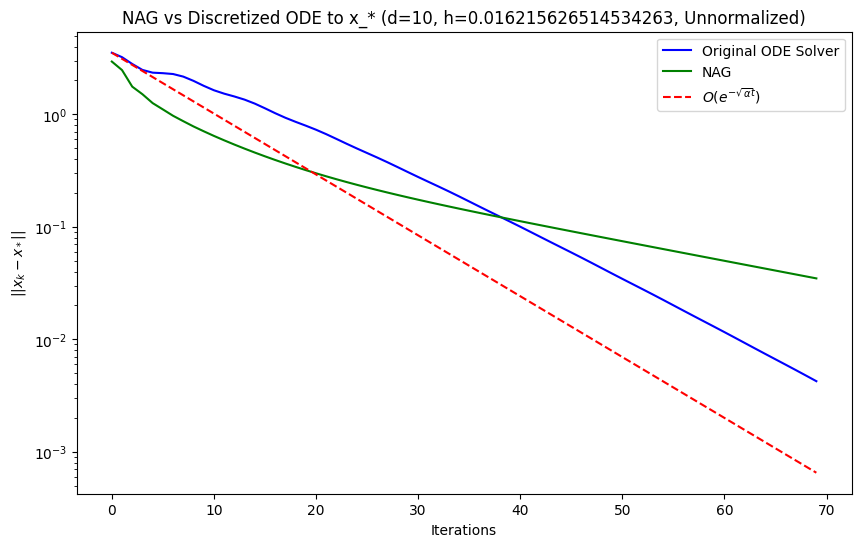

In [3]:
import math
h=1 / (2* math.sqrt(L))
target_function = "quadratic"
if target_function == "logistic":
    objective_function = lambda x: logistic_regression_objective(X, y, x, mu)
else:
    objective_function = lambda x: 0.5 * x.T @ A @ x #- b.T @ x + c

f_vals_ode = []
# Run the discretized ODE solver
for n in range(num_steps):
    f_vals_ode.append(objective_function(x.copy()))
    x_vals.append(x.copy())  # Store x values
    v = np.exp(-gamma * h) * (v + grad_f(x) / gamma) - grad_f(x) / gamma
    x = x + h * v
    print(f"X-value: {x}")
    print(f"V-value: {v}")
    print(f"Gradient: {grad_f(x)}")

x_vals = np.array(x_vals)

# Fit an O(e^{-sqrt(alpha) t}) curve to ||x_n - x_*||
error_norm = np.linalg.norm(x_vals - x_star, axis=1)
t_fit = t_vals
fit_curve = np.exp(-np.sqrt(alpha) * t_fit * h)
fit_curve *= error_norm[0] / fit_curve[0]  # Scale to match initial error

Q = L / max(m, 1e-8)  # Condition number
gamma_k = (np.sqrt(Q) - 1) / (np.sqrt(Q) + 1)  # Nesterov's momentum parameter

# Initialize x and y
x_vals_nag = []
x_k = np.random.randn(d)  # Initial x
y_k = x_k.copy()
f_vals_nag = []


# Run Nesterov's Accelerated Gradient (NAG)
for k in range(num_steps):
    f_vals_nag.append(objective_function(x_k.copy()))
    x_vals_nag.append(x_k.copy())  # Store x values
    y_k1 = x_k - (1 / L) * grad_f(x_k)
    x_k = (1 - gamma_k) * y_k1 + gamma_k * y_k
    y_k = y_k1

x_vals_nag = np.array(x_vals_nag)

# Compute error norm ||x_k - x_*||
error_norm_nag = np.linalg.norm(x_vals_nag - x_star, axis=1)

# Plot results
normalization_status = "Normalized" if normalized else "Unnormalized"
title = f"NAG vs Discretized ODE to x_* (d={d}, h={h}, {normalization_status})"


# Plot NAG convergence vs. original method
plt.figure(figsize=(10, 6))
plt.plot(t_vals, error_norm, label="Original ODE Solver", color="blue")
plt.plot(t_vals, error_norm_nag, label="NAG", color="green")
plt.plot(t_fit, fit_curve, "--", label=r"$O(e^{-\sqrt{\alpha} t})$", color="red")
plt.xlabel("Iterations")
plt.ylabel(r"$||x_k - x_*||$")
plt.yscale("log")
plt.legend()
plt.title(title)
plt.show()


# # Plot results with updated title
# plt.figure(figsize=(10, 6))
# plt.plot(t_vals, error_norm, label=r"$||x_n - x_*||$", color="blue")
# plt.plot(t_fit, fit_curve, "--", label=r"$O(e^{-\sqrt{\alpha} t})$", color="red")
# plt.xlabel("Iterations")
# plt.ylabel(r"$||x_n - x_*||$")
# plt.yscale("log")
# plt.legend()
# plt.title(title)
# plt.show()


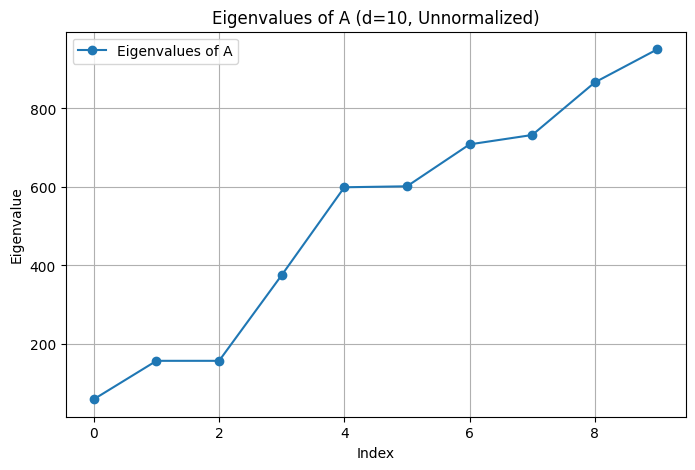

In [4]:
# Compute eigenvalues of A
eigenvalues = eigh(A, eigvals_only=True)

# Plot eigenvalues
plt.figure(figsize=(8, 5))
plt.plot(np.sort(eigenvalues), 'o-', label="Eigenvalues of A")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.title(f"Eigenvalues of A (d={d}, {normalization_status})")
plt.legend()
plt.grid(True)
plt.show()

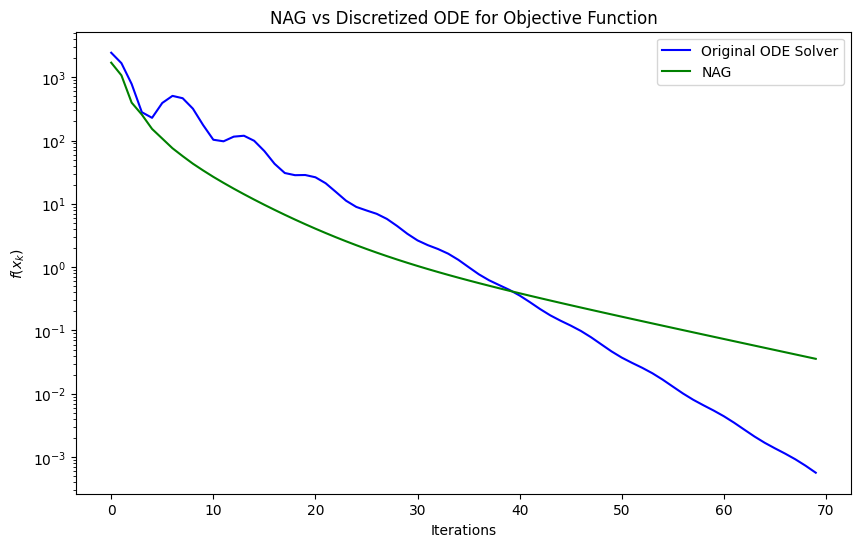

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(t_vals, f_vals_ode, label="Original ODE Solver", color="blue")
plt.plot(t_vals, f_vals_nag, label="NAG", color="green")
plt.xlabel("Iterations")
plt.ylabel(r"$f(x_k)$")
plt.yscale("log")
plt.legend()
plt.title("NAG vs Discretized ODE for Objective Function")
plt.show()

In [ ]:
print(f_vals_ode)

[266.71448837520114, 177.79321253542344, 101.66264917319751, 101.05970566759846, 167.30758524538516, 251.24762573882415, 307.9136034724378, 320.33160065880844, 297.2142072043524, 257.80937614776667, 218.53441048818146, 187.80220401850553, 167.45932200020616, 156.3086580837685, 152.52491765592592, 154.3294292865442, 159.81263491631475, 166.85397235042595, 173.4350757766069, 178.10370138664132, 180.24819049896996, 180.04629250189038, 178.17982424254652, 175.4957106661849, 172.74889808340222, 170.47045131830234, 168.93810569965044, 168.20707300807823, 168.16837241869854, 168.6162412096173, 169.31361588849416, 170.0464955430826, 170.6596854373183, 171.07071109537438, 171.26434397623356, 171.27445274056006, 171.16117640303204, 170.98999812880757, 170.8165818598503, 170.67858226340468, 170.5937633452815, 170.5627549939057, 170.57444183199644, 170.6120949634313, 170.65876629823444, 170.70103942117714, 170.73083695523505, 170.74549168492862, 170.74660700130696, 170.7383374550708, 170.725650190